In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, exp, cos, log, trigsimp, nsimplify, pi, lambdify, diff, solve, N
from scipy.optimize import minimize
from scipy.signal import find_peaks
from scipy.optimize import differential_evolution
from joblib import Parallel, delayed
from tqdm import tqdm

#h, k, beta, gamma = symbols(("h","\kappa",r"\beta", "\gamma"))

#N = 8

#d = 4
def calc_run(N):
    pi = np.pi

    #N = 12

    d = 4

    def c(h,k):
        c_val = 0
        for n in range(N):
            c_val += np.exp(2*(h*np.cos(2*pi*n/N) + k*np.cos(4*pi*n/N)))

        return c_val

    def t(h,k):
        t_val = 0
        for n in range(N):
            t_val += 2*np.cos(2*pi*n/N)*np.exp(2*(h*np.cos(2*pi*n/N) + k*np.cos(4*pi*n/N)))

        return t_val/c(h,k)

    def u(h,k):
        u_val = 0
        for n in range(N):
            u_val += 2*np.cos(4*pi*n/N)*np.exp(2*(h*np.cos(2*pi*n/N) + k*np.cos(4*pi*n/N)))

        return u_val/c(h,k)

    # def c(h,k):
    #     c_val = 0
    #     for n in range(N):
    #         c_val += np.exp((h*np.exp(1j*2*pi*n/N) + k*np.exp(1j*4*pi*n/N))+np.conj((h*np.exp(1j*2*pi*n/N) + k*np.exp(1j*4*pi*n/N))))

    #     return c_val

    # def t(h,k):
    #     t_val = 0
    #     for n in range(N):
    #         t_val += (np.exp(1j*2*pi*n/N)+np.exp(-1j*2*pi*n/N))*np.exp((h*np.exp(1j*2*pi*n/N) + k*np.cos(1j*4*pi*n/N)) + np.conj((h*np.exp(1j*2*pi*n/N) + k*np.cos(1j*4*pi*n/N))))

    #     return t_val/c(h,k)

    # def u(h,k):
    #     u_val = 0
    #     for n in range(N):
    #         u_val += (np.exp(1j*4*pi*n/N)+np.exp(-1j*4*pi*n/N))**np.exp((h*np.exp(1j*2*pi*n/N) + k*np.cos(1j*4*pi*n/N)) + np.conj((h*np.exp(1j*2*pi*n/N) + k*np.cos(1j*4*pi*n/N))))

    #     return u_val/c(h,k)

    def F_func(h,k,beta,gamma):
        return (-d*np.log(c(h,k)) + d*t(h,k)*(h - (1/2)*(d-1)*beta*t(h,k)**3) + d*u(h,k)*(k - (1/2)*(d-1)*gamma*u(h,k)**3))
    # def F_func(h,k,beta,gamma):
    #    return -np.log(c(h,k)) + k*u(h,k) + h*t(h,k) - 0.5*(d-1)*gamma*(u(h,k)**4) - 0.5*(d-1)*beta*(t(h,k)**4)

    # Lambdify to create a NumPy-compatible function
    #f_func = lambdify((x, y), f_sym, modules='numpy')






    #F_func = lambdify((h, k, beta, gamma), F, modules='numpy')

    def calc(beta_val):
        #beta_val = 1.2
        def critical(gamma_val):
            # 3. Fix z and t

            
            #gamma_val = 1.2
            def heat_cap(h, k):
                return u(h,k)
            def mu(h,k):
                #return (1+u(h,k) - 2*t(h,k)**2)
                return (1 - 2*u(h,k) + t(h,k)**2)
                #return  u(h,k) - t(h,k)**2
            
            def out(h, k):
                val = [h,k]
                return val

            # Define function for minimizer
            def f_to_minimize(vars):
                return F_func(*vars,beta_val,gamma_val)

            # Initial guess
            initial_guess = [1, 1]
            bounds = [(0, None),  # x ≥ 0
                    (0, None)]  

            result = differential_evolution(
                f_to_minimize,
                bounds=[(0, 50), (0, 50)],
                strategy='best1bin',
                maxiter=7000,
                popsize=250,
                tol=1e-14,
                polish=True,   # optional local refinement (uses L-BFGS-B)
            )

            # Output result
            #print("Minimum at:", result.x)
            #print("Function value:", (mu(*result.x)))
            h, k = result.x
            return [mu(h,k), heat_cap(h,k), [h,k]]


        Num_points = 100
        
        gammas = np.linspace(-2,2,Num_points)
        mus = np.zeros(Num_points)
        crits_hk = [np.array([]) for _ in range(Num_points)]
        hc_list = np.zeros(Num_points)
        for i,j in enumerate(gammas):
            mu_temp, hc_temp, crit_hk_temp = critical(j)
            mus[i] = mu_temp
            hc_list[i] = hc_temp
            crits_hk[i] = crit_hk_temp


        return mus, hc_list, crits_hk
        #plt.scatter(gammas, mus)

    beta_list = np.linspace(0, 4, int(14*8))
    mus_list = []
    heat_caps = []
    crits = []

    #gammas_list = np.linspace(-1.1,2.0,130)

    #for i in tqdm(beta_list):
    #    mus_list.append(calc(i))
        
        
    results  = Parallel(n_jobs=14)(
        delayed(calc)(beta) for beta in tqdm(beta_list)
    )
        
    mus_list, heat_caps, crits = zip(*results)
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, exp, cos, log, trigsimp, nsimplify, pi, lambdify, diff, solve, N
from scipy.optimize import minimize
from scipy.signal import find_peaks
from scipy.optimize import differential_evolution
from joblib import Parallel, delayed
from tqdm import tqdm

#h, k, beta, gamma = symbols(("h","\kappa",r"\beta", "\gamma"))

    
    return mus_list, heat_caps, crits

N_mus_list = []
N_heat_caps = []
N_crits = []

for i in range(2,13):
    temp_mus, temp_hc, temp_crit = calc_run(i)
    N_mus_list.append(temp_mus)
    N_heat_caps.append(temp_hc)
    N_crits.append(temp_crit)
    
print(N_crits)

In [3]:
import sympy as sp

h, k, beta, gamma = sp.symbols(("h","\kappa",r"\beta", "\gamma"))

N = 2


def c(h,k):
        c_val = 0
        for n in range(N):
            c_val += sp.exp((h*sp.cos(2*sp.pi*n/N))+ (k*sp.cos(4*sp.pi*n/N)))

        return c_val
    


def t(h,k):
        t_val = 0
        for n in range(N):
            t_val += sp.cos(2*sp.pi*n/N)*sp.exp((h*sp.cos(2*sp.pi*n/N)) + (k*sp.cos(4*sp.pi*n/N)))

        return t_val/c(h,k)
    
c(h,k)

exp(\kappa - h) + exp(\kappa + h)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, exp, cos, log, trigsimp, nsimplify, pi, lambdify, diff, solve, N
from scipy.optimize import minimize
from scipy.signal import find_peaks
from scipy.optimize import differential_evolution
from joblib import Parallel, delayed
from tqdm import tqdm

h, k, beta, gamma = symbols(("h","\kappa",r"\beta", "\gamma"))

N = 2

#d = 4

pi = sp.pi

#N = 12

d = 4

def c(h,k):
    c_val = 0
    for n in range(N):
        c_val += sp.exp((h*sp.cos(2*pi*n/N) + k*sp.cos(4*pi*n/N)))

    return c_val

def t(h,k):
    t_val = 0
    for n in range(N):
        t_val += 2*sp.cos(2*pi*n/N)*sp.exp((h*sp.cos(2*pi*n/N) + k*sp.cos(4*pi*n/N)))

    return t_val/c(h,k)

def u(h,k):
    u_val = 0
    for n in range(N):
        u_val += sp.cos(4*pi*n/N)*sp.exp((h*sp.cos(2*pi*n/N) + k*sp.cos(4*pi*n/N)))

    return u_val/c(h,k)

# def c(h,k):
#     c_val = 0
#     for n in range(N):
#         c_val += np.exp((h*np.exp(1j*2*pi*n/N) + k*np.exp(1j*4*pi*n/N))+np.conj((h*np.exp(1j*2*pi*n/N) + k*np.exp(1j*4*pi*n/N))))

#     return c_val

# def t(h,k):
#     t_val = 0
#     for n in range(N):
#         t_val += (np.exp(1j*2*pi*n/N)+np.exp(-1j*2*pi*n/N))*np.exp((h*np.exp(1j*2*pi*n/N) + k*np.cos(1j*4*pi*n/N)) + np.conj((h*np.exp(1j*2*pi*n/N) + k*np.cos(1j*4*pi*n/N))))

#     return t_val/c(h,k)

# def u(h,k):
#     u_val = 0
#     for n in range(N):
#         u_val += (np.exp(1j*4*pi*n/N)+np.exp(-1j*4*pi*n/N))**np.exp((h*np.exp(1j*2*pi*n/N) + k*np.cos(1j*4*pi*n/N)) + np.conj((h*np.exp(1j*2*pi*n/N) + k*np.cos(1j*4*pi*n/N))))

#     return u_val/c(h,k)

def F_func(h,k,beta,gamma):
    return (-d*sp.ln(c(h,k)) + d*t(h,k)*(h - (1/2)*(d-1)*beta*t(h,k)**3) + d*u(h,k)*(k - (1/2)*(d-1)*gamma*u(h,k)**3))

F_func(h,k,beta,gamma)

-6.0*\gamma + 4*\kappa + 4*(-1.5*\beta*(-2*exp(\kappa - h) + 2*exp(\kappa + h))**3/(exp(\kappa - h) + exp(\kappa + h))**3 + h)*(-2*exp(\kappa - h) + 2*exp(\kappa + h))/(exp(\kappa - h) + exp(\kappa + h)) - 4*log(exp(\kappa - h) + exp(\kappa + h))

In [73]:
import sympy as sp
import numpy as np
from scipy.optimize import minimize
from scipy.signal import find_peaks
from scipy.optimize import differential_evolution
from joblib import Parallel, delayed
from tqdm import tqdm

h, k, beta, gamma = sp.symbols(("h","\kappa",r"\beta", "\gamma"))

d = 4

N = 6

def funcs(group_elements, group_n):
    expr = 0
    for expr_i, size in zip(group_elements, group_n):
        expr += 2 * size * sp.exp((h*sp.re(expr_i) + k*sp.re(expr_i**2))/2)
        

    
    c_out = sp.ln(sp.simplify(expr))
    
    t_out = sp.diff(c_out, h)
    
    u_out = sp.diff(c_out, k)
    
    return c_out, t_out, u_out

ns = np.arange(0,N)

# g_test = np.exp(2*np.pi*1j*ns/N)
# g_n = np.ones(N)

def w(n):
    return (sp.exp(2*sp.pi*sp.I/3))**n

def p(n):
    return (sp.exp(2*sp.pi*sp.I/9))**n

def s(n):
    return (p(n)*(1+2*w(n)))**n

u1 =(1-sp.sqrt(5))/2

u2 = (1+sp.sqrt(5))/2

g_test = [2,-2,-1,0,(-1+sp.sqrt(5))/2,(-1-sp.sqrt(5))/2,1,(1+sp.sqrt(5))/2,(1-sp.sqrt(5))/2]
g_n = [1,1,20,30,12,12,20,12,12]

def F_func(h,k,beta,gamma):
    return (-d*funcs(g_test, g_n)[0] + d*funcs(g_test, g_n)[1]*(h - (1/2)*(d-1)*beta*funcs(g_test, g_n)[1]**3) + d*funcs(g_test, g_n)[2]*(k - (1/2)*(d-1)*gamma*funcs(g_test, g_n)[2]**3))    
    

F = F_func(h,k,beta,gamma)
U = funcs(g_test, g_n)[2]    
T = funcs(g_test, g_n)[1]  
F_func = sp.lambdify((h, k, beta, gamma), F, modules='numpy')
u = sp.lambdify((h, k), U, modules='numpy')
t = sp.lambdify((h, k), T, modules='numpy')
def calc(beta_val):
        #beta_val = 1.2
        def critical(gamma_val):
            # 3. Fix z and t

            
            #gamma_val = 1.2
            def heat_cap(h, k):
                return u(h,k)
            def mu(h,k):
                #return (1+u(h,k) - 2*t(h,k)**2)
                return (1 - 2*u(h,k) + t(h,k)**2)
                #return  u(h,k) - t(h,k)**2
            
            def out(h, k):
                val = [h,k]
                return val

            # Define function for minimizer
            def f_to_minimize(vars):
                return F_func(*vars,beta_val,gamma_val)

            # Initial guess
            initial_guess = [1, 1]
            bounds = [(0, None),  # x ≥ 0
                    (0, None)]  

            result = differential_evolution(
                f_to_minimize,
                bounds=[(0, 50), (0, 50)],
                strategy='best1bin',
                maxiter=7000,
                popsize=250,
                tol=1e-14,
                polish=True,   # optional local refinement (uses L-BFGS-B)
            )

            # Output result
            #print("Minimum at:", result.x)
            #print("Function value:", (mu(*result.x)))
            h, k = result.x
            return [mu(h,k), heat_cap(h,k), [h,k]]


        Num_points = 120
        
        gammas = np.linspace(-0.5,0.5,Num_points)
        mus = np.zeros(Num_points)
        crits_hk = [np.array([]) for _ in range(Num_points)]
        hc_list = np.zeros(Num_points)
        for i,j in enumerate(gammas):
            mu_temp, hc_temp, crit_hk_temp = critical(j)
            mus[i] = mu_temp
            hc_list[i] = hc_temp
            crits_hk[i] = crit_hk_temp


        return mus, hc_list, crits_hk
        #plt.scatter(gammas, mus)

beta_list = np.linspace(0, 6.5, int(14*9))
mus_list = []
heat_caps = []
crits = []

    #gammas_list = np.linspace(-1.1,2.0,130)

    #for i in tqdm(beta_list):
    #    mus_list.append(calc(i))
        
        
results  = Parallel(n_jobs=14)(
    delayed(calc)(beta) for beta in tqdm(beta_list)
)
        
mus_list, heat_caps, crits = zip(*results)
    
























100%|██████████| 126/126 [1:59:38<00:00, 56.98s/it]


In [82]:
np.save('ord_param_BI_fine_2_data.npy', mus_list)
np.save('ord_param_BI_fine_2_data_heat_cap_u.npy', heat_caps)
np.save('ord_param_BI_fine_2_data_crits_u.npy', crits)


2.7039999999999997


Text(0.5, 1.0, 'Heat Capacity vs $\\gamma$ for $\\mathbb{Z}$$6$')

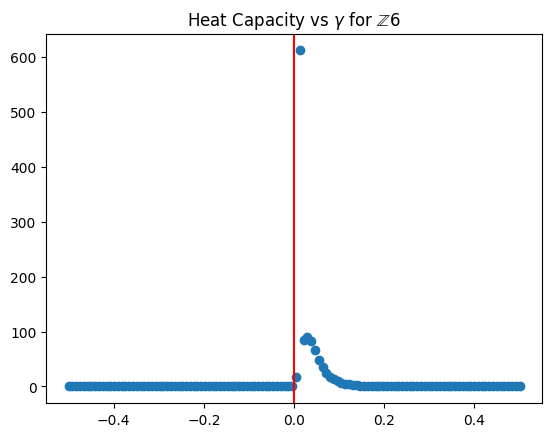

In [81]:
import matplotlib.pyplot as plt

gammas_list = np.linspace(-0.5,0.5, 120)

N_val = 52
d_heat = 2*np.gradient(heat_caps[N_val], gammas_list)*(heat_caps[N_val])**3
print(beta_list[N_val])
plt.scatter(gammas_list, d_heat)
plt.axvline(x=0, color = "red")
#plt.ylim(0,0.1)
plt.title(r"Heat Capacity vs $\gamma$ for $\mathbb{Z}$" + f"${N}$")

2.8378378378378377


Text(0.5, 1.0, 'Heat Capacity vs $\\gamma$ for $\\mathbb{Z}$$6$')

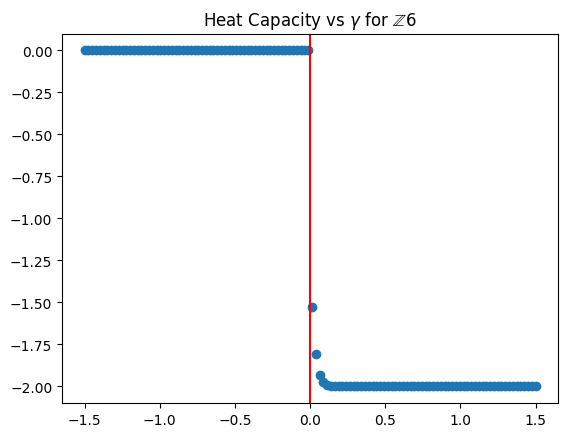

In [72]:
import matplotlib.pyplot as plt


N_val = 45
d_heat = 2*np.gradient(heat_caps[N_val], gammas_list)*(heat_caps[N_val])**3
print(beta_list[N_val])
plt.scatter(gammas_list, mus_list[N_val])
plt.axvline(x=0, color = "red")
#plt.ylim(0,0.1)
plt.title(r"Heat Capacity vs $\gamma$ for $\mathbb{Z}$" + f"${N}$")
#mus_list[N_val]

In [14]:
print(heat_caps)

(array([7.94791408e-09, 2.82052783e-09, 3.33064108e-09, 2.71440907e-09,
       2.84913488e-09, 9.73473097e-09, 3.76838772e-09, 1.58260348e-09,
       6.97821647e-09, 3.23220484e-09, 3.56534280e-09, 1.53243897e-09,
       5.14197876e-09, 7.96241073e-09, 7.06401664e-09, 3.08169927e-09,
       2.01455800e-09, 3.25438326e-09, 8.77705769e-09, 9.55815221e-09,
       7.08786741e-09, 8.67031263e-09, 5.19505964e-09, 4.27085985e-09,
       4.30119904e-09, 4.10149233e-09, 6.86779534e-09, 8.17117117e-09,
       6.90850706e-09, 4.55657206e-09, 2.24811243e-09, 2.73340068e-09,
       8.20107634e-09, 5.40005893e-09, 4.78028112e-09, 9.29024107e-09,
       7.13185394e-09, 5.51925624e-09, 4.79816628e-09, 9.47509509e-09,
       6.84681578e-09, 3.00000000e+00, 3.00000000e+00, 3.00000000e+00,
       3.00000000e+00, 3.00000000e+00, 3.00000000e+00, 3.00000000e+00,
       3.00000000e+00, 3.00000000e+00, 3.00000000e+00, 3.00000000e+00,
       3.00000000e+00, 3.00000000e+00, 3.00000000e+00, 3.00000000e+00,
     